In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.contrib.gp as gp
import scipy.linalg
import torch

rng = np.random.default_rng(seed=1209)
plt.style.use("ggplot")
pyro.clear_param_store()


## Compute $x$ and $w$

In [54]:
l = 101
x = np.linspace(0, 1, l)
w = np.full(l, 1 / (l - 1))
w[0] = w[-1] = 1 / (2 * l - 2)

## Define our choice of kernel from B1

In [55]:
# RBF length 0.46064215898513794 var 1.2840211391448975
# PERIODIC per 0.17793160676956177 length 3.9094502925872803 var 1.4371237754821777

rbf = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(1.2840211391448975),
    lengthscale=torch.tensor(0.460642158),
)

periodic = gp.kernels.Periodic(
    input_dim=1,
    variance=torch.tensor(1.4371237754821777),
    lengthscale=torch.tensor(3.9094502925872803),
    period=torch.tensor(0.17793160676956177),
)


kernel = gp.kernels.Product(kern0=rbf, kern1=periodic)


In [56]:
def compute_kernel_matrix(kernel, x, y):
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)
    return kernel.forward(x, y).detach().numpy()


## Plotting of 5 samples from $f | X, \hat{q}$ for $\hat{q} \in [0,5,10]$

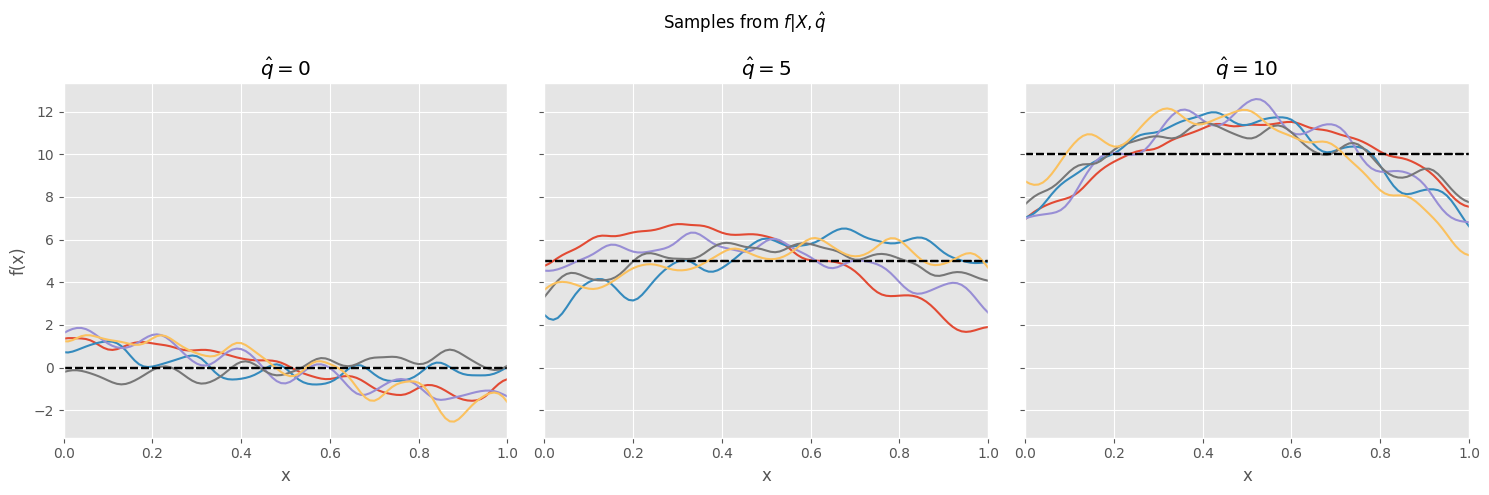

In [71]:
# Number of samples to draw
samples = 5

# Compute kernel matrix for $x_i = \frac{i-1}{l-1}$ and $x_j = \frac{j-1}{l-1}$
Kx = compute_kernel_matrix(kernel, x, x)

# Share x-axis and y-axis for better comparison
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

for i, q_hat in enumerate([0, 5, 10]):
    # Compute mean and covariance of the conditional distribution given $X$ and $\hat{q}$
    Kx_w = Kx @ w
    w_Kx_w = w @ Kx_w

    mu = Kx_w / w_Kx_w * q_hat
    cov = Kx - np.outer(Kx_w / w_Kx_w, Kx_w)

    L = scipy.linalg.cholesky(cov + 1e-10 * np.eye(len(x)), lower=True)

    # Draw samples from the conditional distribution
    for _ in range(samples):
        sample = mu + L @ np.random.normal(0, 1, len(x))
        ax[i].plot(x, sample)
        ax[i].hlines(q_hat, 0, 1, colors="black", linestyles="--")

        # print(np.sum(sample * w))

    ax[i].set(title=r"$\hat{q}=$" + f"{q_hat}", xlabel="x", xlim=(0, 1))
    if i == 0:
        ax[i].set(ylabel="f(x)")

fig.suptitle(r"Samples from $f | X, \hat{q}$ ")
plt.tight_layout()
plt.savefig("./figures/samples_f_given_X_q.png", dpi=600)
plt.show()


In [58]:
def g(x):
    return -(np.sin(6 * np.pi * x) ** 2) + 6 * x**2 - 5 * x**4 + 3 / 2


In [59]:
# Observation data
D_X = np.array([0, 0.25, 0.5])
D_y = np.array([1.46, 0.93, 2.76])

# Kernel matrix for the observation points
K_D = compute_kernel_matrix(kernel, D_X, D_X)


In [60]:
# Add noise variance to the diagonal
noise_variance = 0.01
K_D += np.eye(len(D_X)) * noise_variance

# Inverse of the kernel matrix
K_D_inv = np.linalg.inv(K_D)


(3, 3)

In [61]:
# Grid points
X = np.linspace(0, 1, 101)
K = compute_kernel_matrix(kernel, x, x)


In [62]:
# Cross-covariance between grid points and observation points
K_sD = compute_kernel_matrix(kernel, D_X, x)
K_sD.shape


(3, 101)

In [94]:
# Posterior mean and covariance without constraint (f|D)
mu_f_D = K_sD.T @ K_D_inv @ D_y
Sigma_f_D = K - K_sD.T @ K_D_inv @ K_sD


In [65]:
# Cholesky decomposition for sampling
L_f_D = scipy.linalg.cholesky(Sigma_f_D + 1e-9 * np.eye(len(X)), lower=True)


In [66]:
# Sample 5 times from the posterior f|D
samples_f_D = [mu_f_D + L_f_D @ np.random.normal(size=len(X)) for _ in range(5)]
std_f_D = np.sqrt(np.diag(Sigma_f_D))


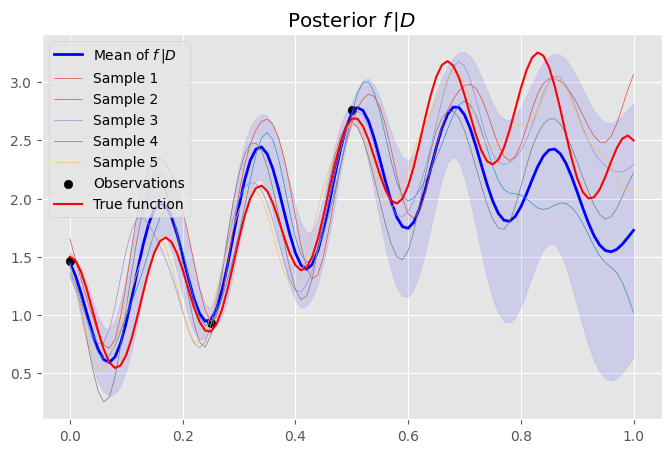

In [103]:
# Plotting the mean and samples for f|D
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(X, mu_f_D, label=r"Mean of $f\, \vert D$", linewidth=2, color="blue")
ax.fill_between(X, mu_f_D - std_f_D, mu_f_D + std_f_D, color="blue", alpha=0.1)
for i, sample in enumerate(samples_f_D):
    ax.plot(X, sample, lw=0.5, label=f"Sample {i+1}")
ax.scatter(D_X, D_y, color="black", marker="o", label="Observations")
ax.set_title(r"Posterior $f\, \vert D$")
ax.plot(x, g(x), color="red", label="True function")
plt.legend()
plt.show()

In [108]:
# Integral constraint q_hat
q_hat = 2

# Compute the weights for the trapezoidal rule
# l = len(x)  # Number of points in the grid
# w = np.array([1 / (2 * (l - 1)) if i in [0, l - 1] else 1 / (l - 1) for i in range(l)])

# Adjusting the mean and covariance for the integral constraint
# New mean
mu_q_hat = q_hat + mu_f_D
# New covariance
Sigma_q_hat = Sigma_f_D  # - np.outer(K @ w, w @ K) / (w @ K @ w)

std_f_D_q = np.sqrt(np.diag(Sigma_q_hat))


In [109]:
mu_q_hat.shape, Sigma_q_hat.shape

((101,), (101, 101))

In [110]:
# Cholesky decomposition for sampling
L_q_hat = scipy.linalg.cholesky(Sigma_q_hat + 1e-2 * np.eye(len(X)), lower=True)

# Sample 5 times from the posterior f|q̂,D
samples_q_hat = [mu_q_hat + L_q_hat @ np.random.normal(size=len(X)) for _ in range(5)]


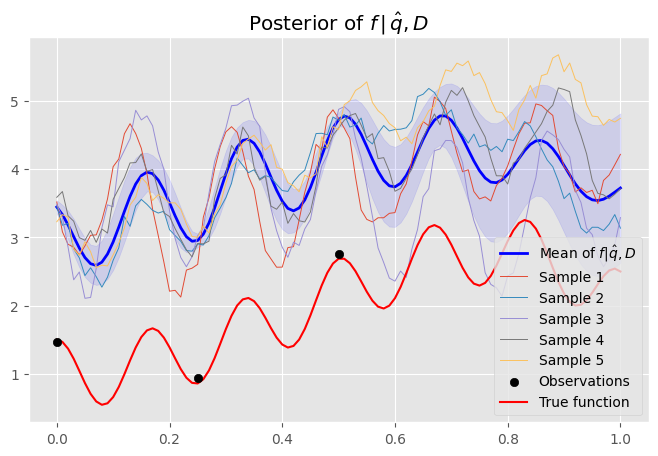

In [111]:
fig, ax = plt.subplots(figsize=(8, 5))


ax.plot(X, mu_q_hat, label=r"Mean of $f \vert \hat{q},D$", linewidth=2, color="blue")
ax.fill_between(X, mu_q_hat - std_f_D_q, mu_q_hat + std_f_D_q, color="blue", alpha=0.1)
for i, sample in enumerate(samples_q_hat):
    ax.plot(X, sample, lw=0.7, label=f"Sample {i+1}")
ax.scatter(D_X, D_y, color="black", marker="o", zorder=5, label="Observations")
ax.set_title(r"Posterior of $f\, \vert \,\hat{q},D$")
ax.plot(x, g(x), color="red", label="True function")
plt.legend()
plt.show()


Yes, given that the covariance matrix of $(q, f \mid X)$ is partitioned into block matrices, it is indeed possible to express the covariance matrix of the conditional distribution $(f \mid X, q)$ in terms of these blocks.

### **Understanding the Block Covariance Matrix**

When dealing with multivariate normal distributions, the joint covariance matrix can be partitioned into blocks corresponding to different subsets of variables. Specifically, for the joint distribution of $(q, f \mid X)$, the covariance matrix $\Sigma$ can be partitioned as:

$$
\Sigma = \begin{bmatrix}
\Sigma_{qq} & \Sigma_{qf} \\
\Sigma_{fq} & \Sigma_{ff} \\
\end{bmatrix}
$$

- $\Sigma_{qq}$ is the covariance matrix of $q$.
- $\Sigma_{ff}$ is the covariance matrix of $f$.
- $\Sigma_{qf}$ (and $\Sigma_{fq} = \Sigma_{qf}^\top$) represents the cross-covariance between $q$ and $f$.

### **Computing the Conditional Covariance Matrix**

For a joint multivariate normal distribution, the conditional distribution of one subset of variables given another is also normal, with its mean and covariance determined by the joint parameters. The covariance matrix of the conditional distribution $(f \mid X, q)$ is given by:

$$
\text{Cov}(f \mid X, q) = \Sigma_{ff} - \Sigma_{fq} \Sigma_{qq}^{-1} \Sigma_{qf}
$$

Here's how this works:

1. **$\Sigma_{ff}$**: Represents the variance (or covariance) of $f$ when considered alone.
2. **$\Sigma_{fq} \Sigma_{qq}^{-1} \Sigma_{qf}$**: Adjusts for the linear relationship between $f$ and $q$ captured in the cross-covariance blocks.

This formula effectively "subtracts out" the part of $f$'s variability that is explained by its linear relationship with $q$, leaving the residual variability that constitutes the covariance of $f$ given $q$.

### **Implications**

- **Direct Computation**: With the block elements $\Sigma_{qq}$, $\Sigma_{qf}$, and $\Sigma_{ff}$, you can directly compute $\text{Cov}(f \mid X, q)$.
- **No Need for Full Distribution**: You don't need to recompute or re-estimate the entire joint distribution; the block components suffice for calculating the conditional covariance.
- **Applicability**: This approach is standard in multivariate statistics and is widely used in fields like Bayesian statistics, signal processing, and machine learning (e.g., in Gaussian processes).

### **Example**

Suppose:

$$
\Sigma = \begin{bmatrix}
\Sigma_{qq} & \Sigma_{qf} \\
\Sigma_{qf}^\top & \Sigma_{ff} \\
\end{bmatrix} = \begin{bmatrix}
\begin{bmatrix}
\sigma_{q1}^2 & \rho_{q1q2} \sigma_{q1} \sigma_{q2} \\
\rho_{q1q2} \sigma_{q1} \sigma_{q2} & \sigma_{q2}^2 \\
\end{bmatrix} & \begin{bmatrix}
\rho_{q1f} \sigma_{q1} \sigma_f \\
\rho_{q2f} \sigma_{q2} \sigma_f \\
\end{bmatrix} \\
\begin{bmatrix}
\rho_{q1f} \sigma_{q1} \sigma_f \\
\rho_{q2f} \sigma_{q2} \sigma_f \\
\end{bmatrix}^\top & \sigma_f^2 \\
\end{bmatrix}
$$

Using the formula:

$$
\text{Cov}(f \mid X, q) = \sigma_f^2 - [\Sigma_{fq}] \Sigma_{qq}^{-1} [\Sigma_{qf}]
$$

You can compute the conditional covariance by plugging in the known values.

When dealing with multivariate normal distributions, understanding the impact of conditioning on the covariance structure is crucial. Let's address your question:

### **Question Recap**

- **Given**: The covariance matrix \(\Sigma_{ff}\) (the covariance of \(f\)) has full rank (i.e., it is positive definite).
- **Question**: Can we say anything about the rank of the conditional covariance matrix \(\text{Cov}(f \mid X, q)\) given this information?

### **Short Answer**

No, even if \(\Sigma_{ff}\) has full rank, we cannot generally infer that \(\text{Cov}(f \mid X, q)\) will also have full rank. The rank of the conditional covariance matrix depends on the relationship between \(f\) and \(q\) encoded in the cross-covariance \(\Sigma_{fq}\). Conditioning can reduce the rank, potentially making \(\text{Cov}(f \mid X, q)\) less than full rank.

---

### **Detailed Explanation**

#### **Understanding the Conditional Covariance**

The conditional covariance of \(f\) given \(q\) (and \(X\)) in a joint Gaussian setting is calculated using the formula:

\[
\text{Cov}(f \mid X, q) = \Sigma_{ff} - \Sigma_{fq} \Sigma_{qq}^{-1} \Sigma_{qf}
\]

- **\(\Sigma_{ff}\)**: Covariance of \(f\), assumed to be full rank (positive definite).
- **\(\Sigma_{qf}\)** and **\(\Sigma_{fq}\)**: Cross-covariance matrices between \(q\) and \(f\).
- **\(\Sigma_{qq}\)**: Covariance of \(q\), assumed to be invertible (positive definite).

#### **Impact of Conditioning on Rank**

1. **Full Rank of \(\Sigma_{ff}\)**:

   - A full-rank \(\Sigma_{ff}\) implies that \(f\) has variability in all its dimensions when considered marginally (without conditioning on \(q\)).

2. **Effect of \(\Sigma_{fq} \Sigma_{qq}^{-1} \Sigma_{qf}\)**:

   - The term \(\Sigma_{fq} \Sigma_{qq}^{-1} \Sigma_{qf}\) represents the part of \(f\)'s variability that is linearly explained by \(q\).
   - This term is **positive semi-definite** because it's of the form \(A B A^\top\) with \(B\) positive definite.

3. **Subtraction Reduces Rank**:

   - Subtracting a positive semi-definite matrix from \(\Sigma_{ff}\) can reduce the rank of the resulting conditional covariance matrix.
   - If \(f\) is highly correlated with \(q\), a significant portion of its variability is "explained away" when conditioning on \(q\), potentially reducing rank.

#### **Possible Scenarios**

1. **No Correlation between \(f\) and \(q\)**:

   - If \(\Sigma_{qf} = 0\), then \(\text{Cov}(f \mid X, q) = \Sigma_{ff}\).
   - In this case, the rank remains full since no variability is removed through conditioning.

2. **Perfect Linear Relationship**:

   - If \(f\) can be expressed as a linear function of \(q\) (i.e., \(f = A q\) deterministically), then:
     - \(\Sigma_{ff} = \Sigma_{fq} \Sigma_{qq}^{-1} \Sigma_{qf}\).
     - \(\text{Cov}(f \mid X, q) = \Sigma_{ff} - \Sigma_{ff} = 0\).
     - The rank of the conditional covariance is zero.

3. **Partial Correlation**:

   - When \(f\) and \(q\) are partially correlated, the rank of \(\text{Cov}(f \mid X, q)\) can be anywhere between full rank and reduced rank, depending on the strength and structure of their relationship.
   - The more \(f\) depends on \(q\), the more the rank is likely to reduce upon conditioning.

#### **Conclusion**

- **Rank Not Guaranteed**: We cannot guarantee that \(\text{Cov}(f \mid X, q)\) will be full rank even if \(\Sigma_{ff}\) is full rank.
- **Dependence on Cross-Covariance**: The reduction in rank depends critically on \(\Sigma_{fq}\) (and \(\Sigma_{qf}\)), which captures the dependence between \(f\) and \(q\).
- **Need for Additional Information**: Without further information about the relationship between \(f\) and \(q\), we cannot make definitive statements about the rank of \(\text{Cov}(f \mid X, q)\).

### **Implications**

- **Positive Semi-Definiteness**: While the conditional covariance matrix \(\text{Cov}(f \mid X, q)\) is always positive semi-definite, its rank may be less than full due to the subtraction of a positive semi-definite matrix.
- **Practical Considerations**: In applications like regression, signal processing, or machine learning, this means that conditioning on certain variables can reduce the effective dimensionality of the uncertainty in \(f\).

---

**Answer:** No; even if Σ_ff has full rank, we cannot generally determine the rank of Cov(f | X, q) without more information—the conditioning on q can reduce the rank, so Cov(f | X, q) may have lower rank depending on the cross-covariance between f and q.